In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from reco_systems.filter import filter_df
from reco_systems.CF_knn import calc_similarity_matrix, get_KNN
from reco_systems.user_game_matrix import get_matrix_user_game

In [13]:
# import DB et set min_reviews
folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"trictrac_database/users.csv", names=["Username", "User id"])



In [15]:
min_reviews = 5
rev_filter = filter_df(avis_clean, min_reviews)

11201 10549
3242 3957
3006 3910
3003 3910


In [16]:
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
cos_sim_matrix, _ = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
cos_sim_matrix

array([[0.        , 0.90631531, 0.84503229, ..., 1.        , 1.        ,
        0.98883848],
       [0.90631531, 0.        , 0.70944996, ..., 0.98849347, 1.        ,
        0.99491711],
       [0.84503229, 0.70944996, 0.        , ..., 1.        , 1.        ,
        0.98260143],
       ...,
       [1.        , 0.98849347, 1.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.98883848, 0.99491711, 0.98260143, ..., 1.        , 1.        ,
        0.        ]], shape=(3003, 3003))

In [ ]:
#users_ids = rev_filter[["User id", "Game id"]].groupby("User id", as_index=True).count().sort_values("Game id", ascending=False).head(5)
users_ids = rev_filter[["User id", "Game id"]].groupby("User id", as_index=True).count()
users_ids = users_ids[(users_ids["Game id"] >= 100) & (users_ids["Game id"] < 420)].sample(12)


assoc = users_table.to_frame().merge(users_ids, left_on="User id", right_index=True).reset_index()
assoc.columns = ["User index", "User id", "Count reviews"]
user_indices = assoc["User index"].to_numpy()
k = int(np.sqrt(3003))

In [24]:
users_dist = np.array([np.delete(cos_sim_matrix[user], user) for user in user_indices]) # avoid taking user himself
users_dist.shape

(5, 3002)

In [32]:
user_distances = np.round(users_dist, 2)
dist_for_df  = user_distances.ravel()
users_for_df = np.repeat(user_indices, 3002)
users_for_df.shape, dist_for_df.shape

((15010,), (15010,))

In [33]:
distance_to_users = pd.DataFrame({"Distance": dist_for_df, "User index":users_for_df}).sort_values("Distance")
distance_to_users = distance_to_users.groupby(["Distance", "User index"], as_index=True).size().reset_index(name="Number of users")
distance_to_users

,Distance,User index,Number of users
0,0.48,1,1
1,0.48,56,1
2,0.58,49,1
3,0.58,56,1
4,0.58,144,2
...,...,...,...
178,1.00,1,247
179,1.00,49,172
180,1.00,56,241
181,1.00,140,326


/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_7938/2599138276.py:3: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(distance_to_users, x="Distance", y="Number of users", hue="User index", scale=0.5,  palette="Spectral")


Text(0.5, 0.98, '5 most active users')

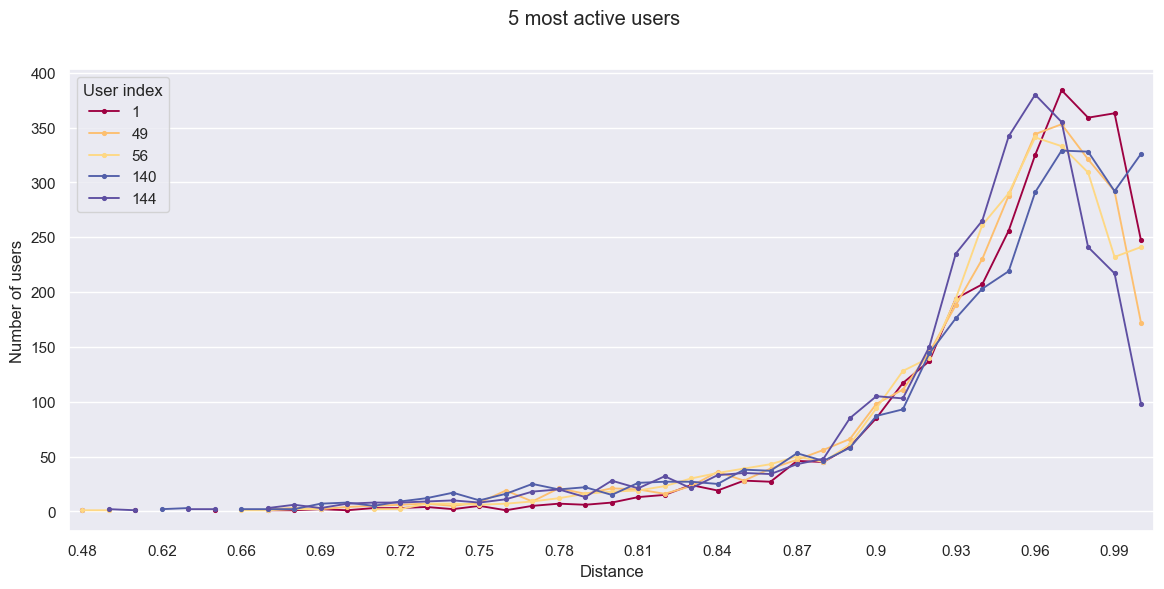

In [38]:
sns.set_theme(rc={'figure.figsize':(14,6)})

ax = sns.pointplot(distance_to_users, x="Distance", y="Number of users", hue="User index", scale=0.5,  palette="Spectral")

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 3 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.figure.suptitle("5 most active users")
# g = sns.FacetGrid(distance_to_users, col="User index", col_wrap=4, xlim=(0.4, 1.))
# g.map(sns.scatterplot, "Distance", "Number of users")
# g.figure.subplots_adjust(top=0.9) 
# g.figure.suptitle("Users [100-420 reviews]. k = 54 cos")